In [521]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [522]:
results = pd.read_csv(f'../results/official_output_29.4_15folds.csv')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 3', '')


results_ood = results[results['evaluation_set'] != 'In-Distribution']
results_ood.loc[:, 'evaluation_set'] = 'Out-of-Distribution'

results_in = results[results['evaluation_set'] == 'In-Distribution']

# Miscoverage
### Generating Samples leaving 3 out

In [523]:
replications = []
for index in range(15):
  if index < 13:
    a = np.arange(1, 16)
    a = np.delete(a, [index, index+1, index+2])
    replications.append(a)
      
replications

[array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]

In [533]:
def generate_miscoverage(df):
  global_15fold_df = df.copy()
  
  each_replication_array = []
  for i, selected_folds in enumerate(replications):
      splitted_dataframe = global_15fold_df[global_15fold_df['fold'].isin(selected_folds)].copy()
      splitted_dataframe['replication'] = i + 1
      each_replication_array.append(splitted_dataframe)

  each_replication_df = pd.concat(each_replication_array, ignore_index=True)
  
  each_leave3out_df = []
  for i, selected_folds in enumerate(replications):
      splitted_dataframe = each_replication_df[each_replication_df['fold'].isin(selected_folds)].copy()
      mean_fscore_overall = each_replication_df.groupby(['approach', 'model', 'replication'])['f1-score(weighted avg)'].mean()

      def normalize_fscore(row):
          strategy = row['approach']
          model = row['model']
          replication = row['replication']
          fscore = row['f1-score(weighted avg)']
          mean = mean_fscore_overall[(strategy, model, replication)]
          return fscore - mean

      dataframe = pd.DataFrame({
          'model': splitted_dataframe['model'],
          'replication': splitted_dataframe['replication'],
          'fold': splitted_dataframe['fold'],
          'evaluation_set': splitted_dataframe['evaluation_set'],
          'approach': splitted_dataframe['approach'] + '_' + str(i),
          'f1-score(weighted avg)': splitted_dataframe.apply(normalize_fscore, axis=1),
      })
      each_leave3out_df.append(dataframe)

  def custom_sort(appr):
      order = {
          'Baseline': 0,
          'DefaultAug': 1,
          'Gaussian': 2,
          'Salt&Pepper': 3,
          'DefaultAug+Gaussian': 4,
          'DefaultAug+S&P': 5
      }
      return order[appr.split('_')[0]]

  result_dataframe = pd.concat(each_leave3out_df, ignore_index=True)
  result_dataframe['sort_key'] = result_dataframe['approach'].apply(custom_sort)
  result_dataframe_final = result_dataframe.sort_values(by=['sort_key', 'approach']).drop(columns=['sort_key'])

  return result_dataframe_final, each_leave3out_df

In [534]:
result_dataframe_in, each_dataframe_fscore_in = generate_miscoverage(results_in)
result_dataframe_ood, each_dataframe_fscore_ood = generate_miscoverage(results_ood)

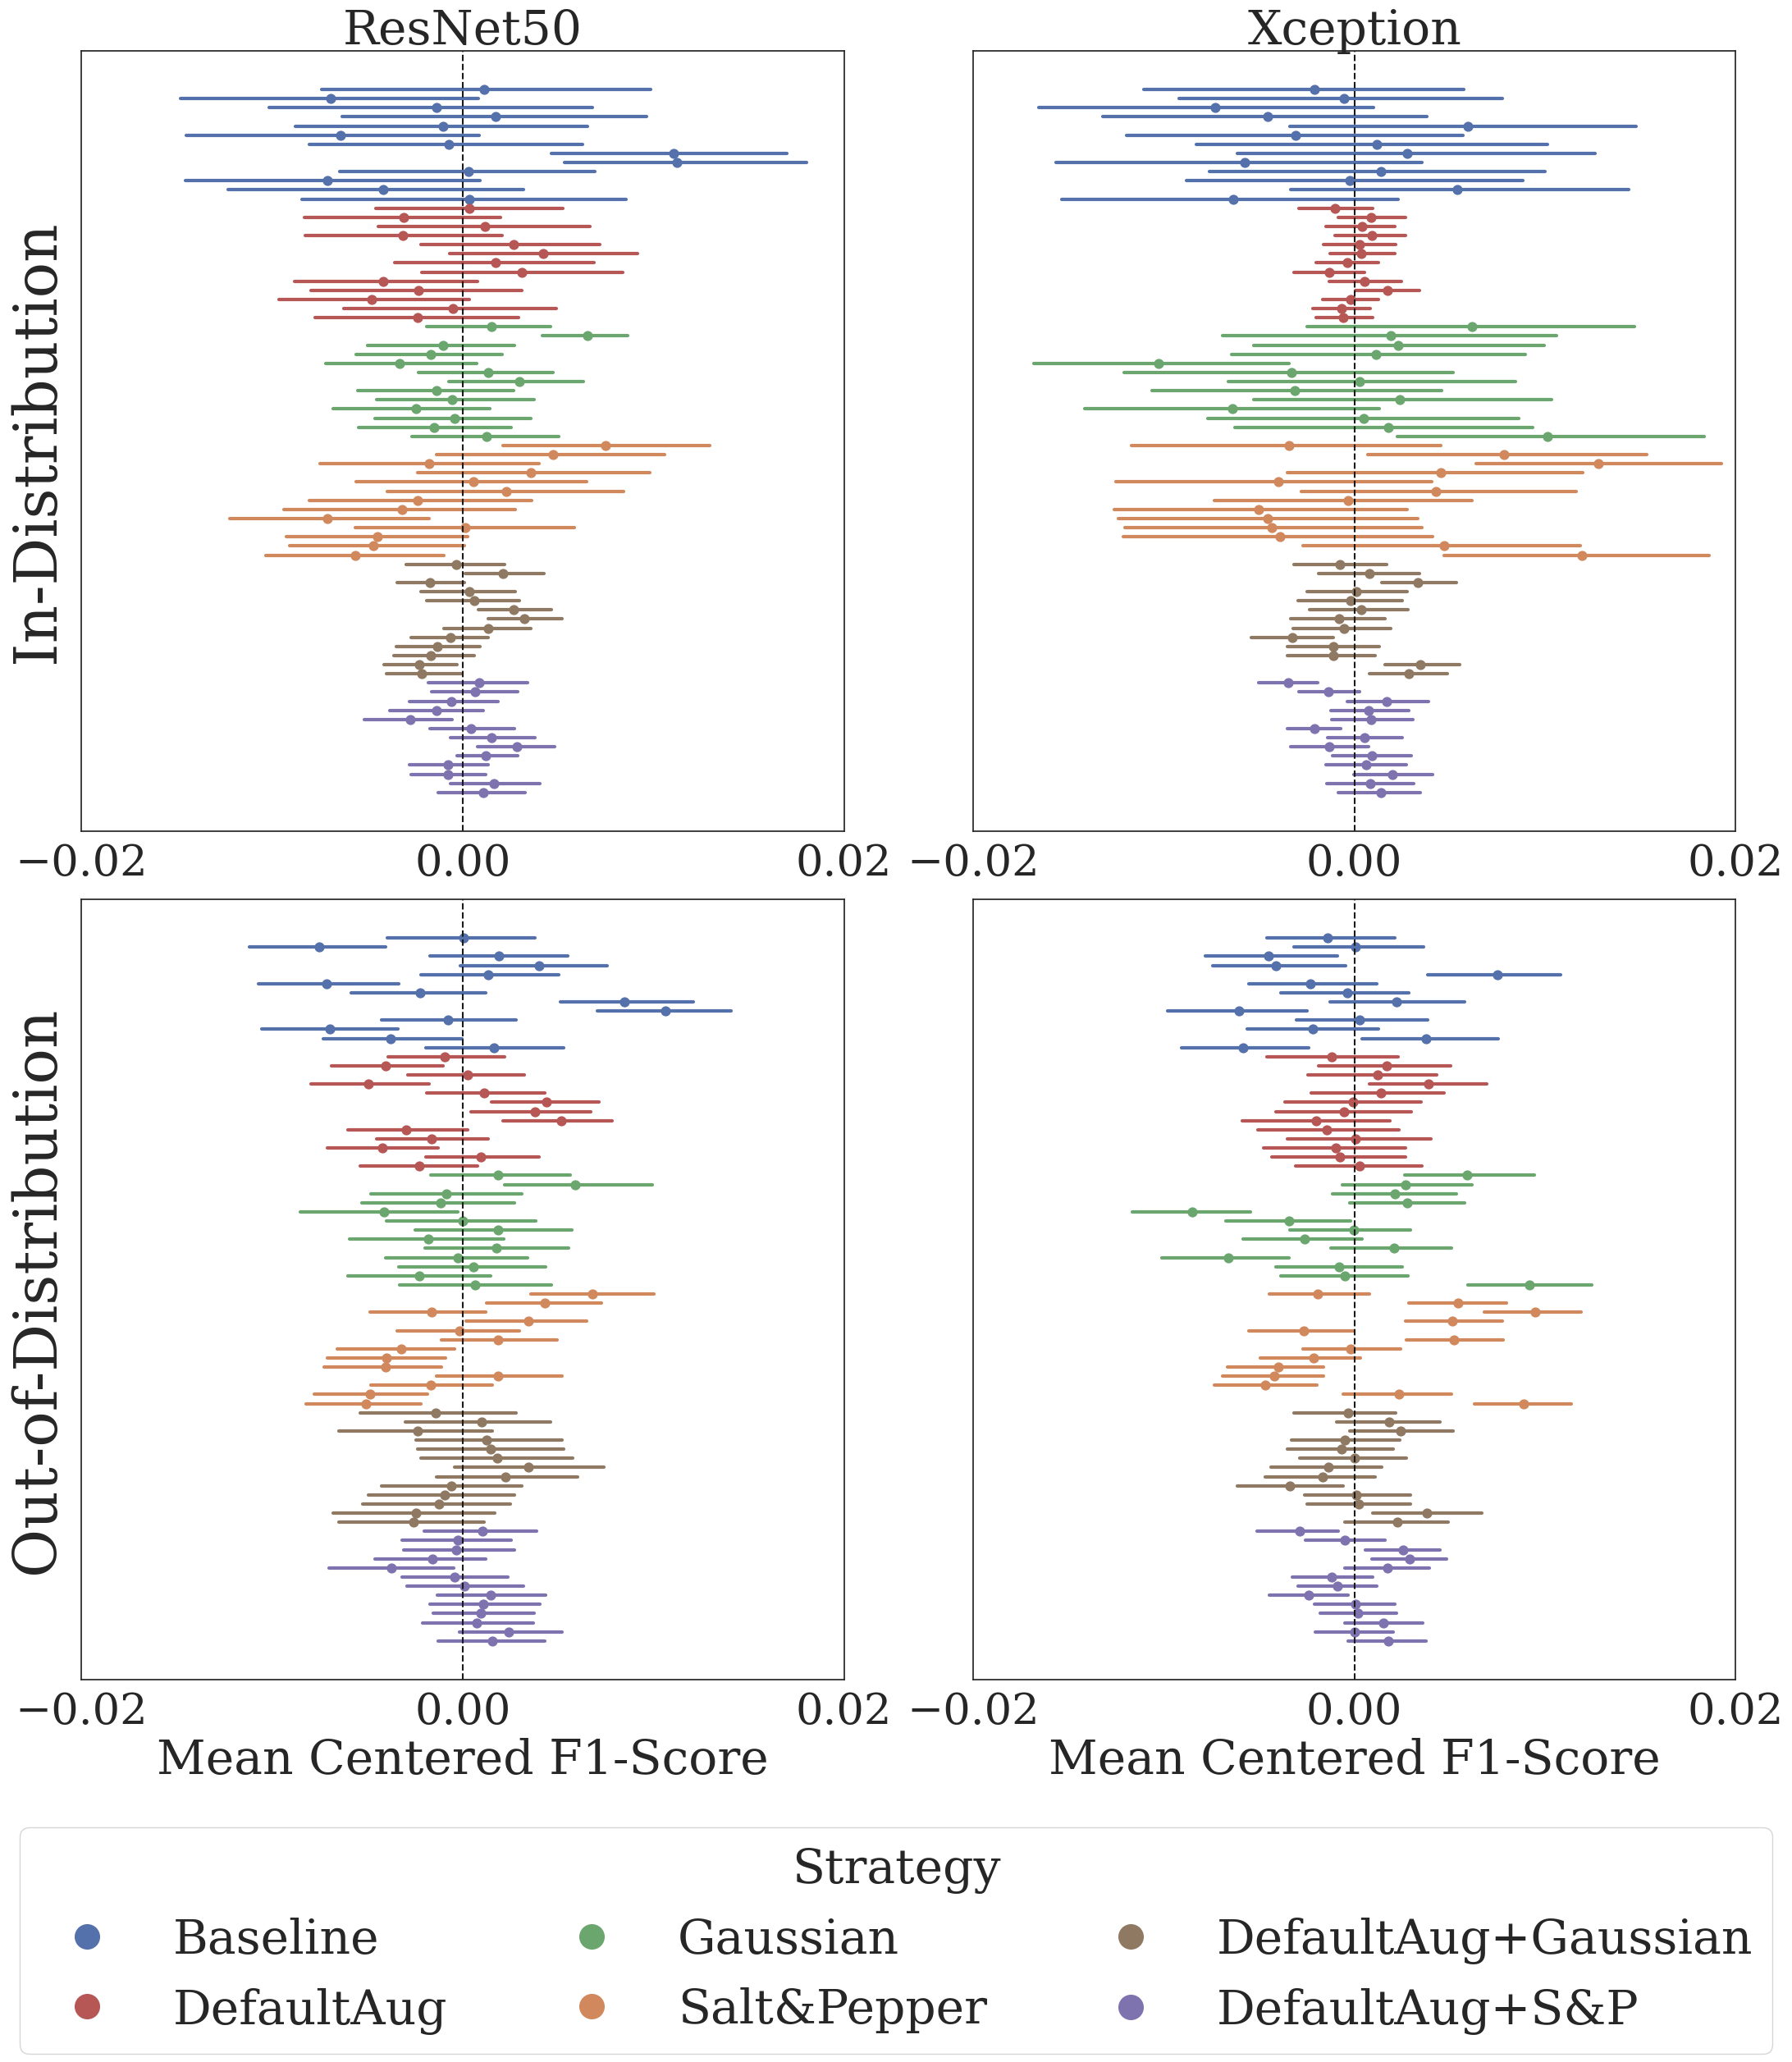

In [535]:
def plot_results_all(df1, df2, x_label='Mean Centered F-Score', figsize=(22, 22)):
    unique_values1 = df1['model'].unique()
    unique_values2 = df2['model'].unique()

    resnet_results = df1[df1['model'] == unique_values1[0]]
    xception_results = df1[df1['model'] == unique_values1[1]]
    resnet_results2 = df2[df2['model'] == unique_values2[0]]
    xception_results2 = df2[df2['model'] == unique_values2[1]]

    fig, axes = plt.subplots(2, 2, figsize=figsize)  # Create a figure with four subplots

    x_min = -.02
    x_max = .02

    x_ticks = [x_min, 0, x_max]

    handles = []
    labels = []

    unique_approaches = df1['approach'].unique()
    palette_dict = {}

    for approach in unique_approaches:
        if approach not in palette_dict:
            if approach.startswith('Baseline'):
                palette_dict['Baseline'] = '#5471ab'
            elif approach.startswith('Gaussian'):
                palette_dict['Gaussian'] = '#6aa66e'
            elif approach.startswith('Salt&Pepper'):
                palette_dict['Salt&Pepper'] = '#d1885c'
            elif approach.startswith('DefaultAug+S&P'):
                palette_dict['DefaultAug+S&P'] = '#7f73af'
            elif approach.startswith('DefaultAug+Gaussian'):
                palette_dict['DefaultAug+Gaussian'] = '#8f7963'
            elif approach.startswith('DefaultAug'):
                palette_dict['DefaultAug'] = '#b65655'

    appr = df1.copy()
    palette = [palette_dict[approach.split('_')[0]] for approach in appr['approach'].unique()]

    for i, plot in enumerate([
        {"df": resnet_results, "model": "ResNet50", "ylabel": "In-Distribution"},
        {"df": xception_results, "model": "Xception", "ylabel": "In-Distribution"},
        {"df": resnet_results2, "model": "", "ylabel": "Out-of-Distribution"},
        {"df": xception_results2, "model": "", "ylabel": "Out-of-Distribution"}
    ]):
        sns.set_style("whitegrid")
        sns.set(font='serif')
        sns.set_style("white", {
            "font.family": "serif",
            "font.serif": ["Times", "Palatino", "serif"],
        })

        ax = sns.pointplot(
            data=plot['df'],
            x='f1-score(weighted avg)',
            y='evaluation_set',
            hue='approach',
            linestyles='none',
            errorbar=("ci", 95),
            dodge=.9,
            palette=palette, 
            err_kws={'linewidth': 3},
            ax=axes[i//2, i%2] 
        )

        ax.set_xlabel(x_label, fontsize=32)

        ax.set_xlim(x_min, x_max)
        ax.set_xticks(x_ticks)

        ax.axvline(x=0, color='k', linestyle='--')
        
        if i == 0 or i == 1:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Mean Centered F1-Score", fontsize=42)

        if i % 2 == 0:
            ax.set_ylabel(plot['ylabel'], fontsize=52)
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        ax.tick_params(labelsize=38)
        ax.set_title(plot['model'], fontsize=42 if plot['model'] else 0)

        ax.legend_.remove()

        if i == 0:
            handles, labels = ax.get_legend_handles_labels()


    for i in range(len(labels)):
        labels[i] = labels[i].split('_')[0]

    unique_labels = []
    unique_handles = []
    for i, label in enumerate(labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])

    fig.legend(unique_handles, unique_labels, title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.155), fontsize=42, title_fontsize=42, ncol=3)

    plt.tight_layout()
    plt.savefig('../output/miscoverage_plot.pdf', bbox_inches='tight')
    plt.show()

plot_results_all(result_dataframe_in, result_dataframe_ood)

# Miscoverage STD DEV

#### In-Distribution

In [527]:
df = pd.concat(each_dataframe_fscore_in)
for model in ['ResNet50', 'Xception']:
  print('\n')
  for approach in ['Baseline', 'Gaussian', 'Salt&Pepper', 'DefaultAug_', 'DefaultAug+Gaussian_', 'DefaultAug+S&P_',]:
      curr_df = df[df['model'] == model]
      curr_df = curr_df[curr_df['approach'].str.startswith(approach)]
      print(f"STD {model} - {approach}:", curr_df['f1-score(weighted avg)'].std())



STD ResNet50 - Baseline: 0.0438193154866146
STD ResNet50 - Gaussian: 0.021772740988012646
STD ResNet50 - Salt&Pepper: 0.03238254415550102
STD ResNet50 - DefaultAug_: 0.029941858902005576
STD ResNet50 - DefaultAug+Gaussian_: 0.012359851421666523
STD ResNet50 - DefaultAug+S&P_: 0.012862805049147592


STD Xception - Baseline: 0.05108947364612907
STD Xception - Gaussian: 0.04541971413809673
STD Xception - Salt&Pepper: 0.043561515382428605
STD Xception - DefaultAug_: 0.00988457900573542
STD Xception - DefaultAug+Gaussian_: 0.013777853769854496
STD Xception - DefaultAug+S&P_: 0.011600141608125959


In [528]:
df

,model,replication,fold,evaluation_set,approach,f1-score(weighted avg)
0,ResNet50,1,4,In-Distribution,Baseline_0,0.061225
1,ResNet50,1,5,In-Distribution,Baseline_0,0.016618
2,ResNet50,1,6,In-Distribution,Baseline_0,-0.072470
3,ResNet50,1,7,In-Distribution,Baseline_0,-0.091701
4,ResNet50,1,8,In-Distribution,Baseline_0,0.014587
...,...,...,...,...,...,...
1867,Xception,13,8,In-Distribution,DefaultAug+Gaussian_12,0.025370
1868,Xception,13,9,In-Distribution,DefaultAug+Gaussian_12,-0.010167
1869,Xception,13,10,In-Distribution,DefaultAug+Gaussian_12,-0.000167
1870,Xception,13,11,In-Distribution,DefaultAug+Gaussian_12,-0.033691


#### Out-of-Distribution

In [529]:
df = pd.concat(each_dataframe_fscore_ood)
for model in ['ResNet50', 'Xception']:
  print('\n')
  for approach in ['Baseline', 'Gaussian', 'Salt&Pepper', 'DefaultAug_', 'DefaultAug+Gaussian_', 'DefaultAug+S&P_',]:
      curr_df = df[df['model'] == model]
      curr_df = curr_df[curr_df['approach'].str.startswith(approach)]

      print(f"STD {model} - {approach}:", curr_df['f1-score(weighted avg)'].std())



STD ResNet50 - Baseline: 0.09022636520301963
STD ResNet50 - Gaussian: 0.09774559098136029
STD ResNet50 - Salt&Pepper: 0.07818402828144852
STD ResNet50 - DefaultAug_: 0.07642305611094295
STD ResNet50 - DefaultAug+Gaussian_: 0.09648778625584752
STD ResNet50 - DefaultAug+S&P_: 0.07406779752866913


STD Xception - Baseline: 0.08702613770021045
STD Xception - Gaussian: 0.08160085060863445
STD Xception - Salt&Pepper: 0.06598519501907137
STD Xception - DefaultAug_: 0.08816050169910294
STD Xception - DefaultAug+Gaussian_: 0.06932417508892373
STD Xception - DefaultAug+S&P_: 0.05215471333739739
